# My TTN library
In this notebook I try to develop my personal library to handle TTNs, their definition, properties, automatic contraction and training.

In [18]:
%load_ext autoreload

In [19]:
%autoreload 2
import torch
import numpy as np
import graphviz
graphviz.set_jupyter_format('png')
from matplotlib import colormaps, colors
import matplotlib.pyplot as plt
import colorsys
from typing import Sequence, ValuesView
from tqdm import tqdm, trange
from string import ascii_letters
from timeit import timeit
from datetime import datetime

from ttn_torch import TIndex, TTNIndex, TTN, TTNModel, check_correct_init
from algebra import contract_up, kron
from utils import adjust_lightness, get_mnist_data_loaders, accuracy, get_stripeimage_data_loaders, get_iris_data_loaders, get_higgs_data_loaders, train_one_epoch
from torchinfo import summary

## TTN with automatic contractions
Try to develop methods to do automatic contractions, also based on the network structure (separability of states)
### Network description

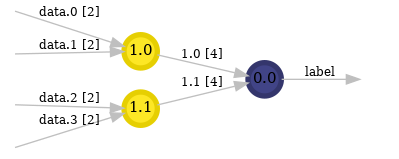

In [4]:
DEVICE = 'cuda'
DTYPE = torch.double
N_FEAT = 4
ttn = TTN(N_FEAT, bond_dim=8, n_labels=2, device=DEVICE, dtype=DTYPE)
ttn.draw()

### Basic operations
General purpose contraction, not optimized

In [9]:
def contract(
        tensors : Sequence[torch.Tensor] | ValuesView[torch.Tensor], 
        tindices: Sequence[TTNIndex | TIndex], 
        keep    : Sequence[str] | None=None, 
        outname : str | None=None
):
    """
    Contract two tensors along the matching TIndices in indices, except for the indices in keep.
    """
    if len(tindices) != len(tensors):
        raise ValueError(f"Expected tensors and tindices to have same lenght, got {len(tensors)} and {len(tindices)}")

    if keep is None:
        keep = []
    elif isinstance(keep, str):
        keep = [keep]
    elif not isinstance(keep, Sequence):
        raise TypeError(f"Expected keep to be None, str or Sequence, got {type(keep)}")

    keep = list(keep)
    unique_inds, counts = np.unique(np.concatenate([tindex.indices for tindex in tindices]), return_counts=True)
    if np.any(np.isin(keep, unique_inds, invert=True)):
        raise ValueError(f"keep contains indices that are not in tindices: {np.asarray(keep)[np.where(np.isin(keep, unique_inds, invert=True))[0]]}")
    if len(unique_inds) > len(ascii_letters):
        raise ValueError(f"Too many indices to contract: {len(unique_inds)} > {len(ascii_letters)}")

    # find output indices (all indices that are not contracted or kept)
    output_inds = unique_inds[np.isin(unique_inds, keep) | (counts == 1)]
    
    # map indices to letters
    idx_to_char_map = {tind: ascii_letters[i] for i, tind in enumerate(unique_inds)}
    
    # contraction strings
    ## tensor indices
    tindices_str = ["..."+"".join([idx_to_char_map[i] for i in tindex.indices]) for tindex in tindices] # the ellipsis is for batch dimension
    ## output indices
    outinds_str = "..."+"".join([idx_to_char_map[i] for i in output_inds])

    #print(tindices_str,'\n' ,outinds_str)
    # contract
    C = torch.einsum(f"{','.join(tindices_str)}->{outinds_str}", *tensors)

    return C, TIndex(f"{min(tindices)}" if outname is None else outname, output_inds)

    

Let's exploit the TTN topology to optimize contractions, i.e. make them go from bottom to top

In [10]:
def contract_up_einsum(tensor: torch.Tensor, data_tensors: Sequence[torch.Tensor]):
    # this function is the fundamental block for TTN contractions:
    # it takes a ttn tensor and two data vectors and contracts them to a new vector

    return torch.einsum('bi,ijk,bj->bk', data_tensors[0], tensor, data_tensors[1])

### Tests

In [11]:
data = torch.rand(N_FEAT, 10, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"{ttn.n_layers}.{i}", [f"data.{i}"]) for i in range(N_FEAT)]

time1 = timeit(lambda: contract_up(ttn.tensors[-1], data[:2]), number=10000)
time2 = timeit(lambda: contract((ttn.tensors[-1],) + data[:2], [ttn.indices[-1]]+data_indices[:2]), number=10000)
time3 = timeit(lambda: contract_up_einsum(ttn.tensors[-1], data[:2]), number=10000)
time1, time2, time3

(0.42125636897981167, 4.402739965997171, 2.430211186001543)

In [12]:
data = torch.rand(N_FEAT, 64, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"data.{i}", [f"data.{i}"]) for i in range(N_FEAT)]
i=1
time1 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0')), number=100)
time2 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0'), keep=True), number=100)
time3 = timeit(lambda: contract(list(ttn.get_branch(f'1.{i}').values()) + list(data[16*i:16*(i+1)]), list(ttn.get_branch(f'1.{i}').keys())+data_indices[16*i:16*(i+1)]), number=100)
print(time1, time2, time3)

0.01044276900938712 0.006214366003405303 0.014277718000812456


TEST the contraction scheme by a synthetic dataset and the TTN initialized to identities

In [13]:
def generate_i_state(n_sites, i, dtype=torch.double):
    """
    Generates a separable state wich would be represented 
    as a vector with 1 at i-th position in the full form.
    """
    sites = []
    bin_str = f'{i:b}'
    bin_str = '0'*(n_sites-len(bin_str)) + bin_str
    for char in bin_str:
        if char == '0':
            sites.append(torch.as_tensor([1.0, 0.0], dtype=dtype))
        else:
            sites.append(torch.as_tensor([0.0, 1.0], dtype=dtype))
 
    state = torch.stack(sites)

    return state


# create general purpose identity tensor
# this is a 3d tensor with 1 on the diagonal
ID = torch.zeros([4, 4, 4], dtype=DTYPE)
for i in range(ID.shape[0]):
    ID[i, i, i] = 1.0
# create data
# you can choose from different states
I = 0 # position of 1 in the resulting state (starting from 0)
test_states = {'up': [1, 0], 'down': [0, 1], 'plus': [1/(2**0.5), 1/(2**0.5)], 'minus': [1/(2**0.5), -1/(2**0.5)], 'i': generate_i_state(N_FEAT, I)}
data = torch.expand_copy(torch.as_tensor(test_states['i'], dtype=DTYPE), [64, N_FEAT, 2])

# transform to data dictionary to pass to _propagate_data_through_branch_
data_dict = {TIndex(f"data.{i}", [f"data.{i}"]): datum for i, datum in enumerate(data.unbind(1))}
# set TTN tensors to identity
ttn.tensors = [torch.eye(tensor.shape[0]**2, dtype=DTYPE).reshape(*tensor.shape[:2], -1)[:,:,:tensor.shape[-1]] for tensor in ttn.tensors] #[ID[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] for tensor in ttn.tensors]
# contract
pbar = tqdm(total=len(ttn.tensors), desc='ttn test', position=0)
result = ttn._propagate_data_through_branch_(data_dict, ttn.get_branch('0.0'), keep=True, pbar=pbar)['0.0']
pbar.close()
result[0]

ttn test: 100%|██████████| 3/3 [00:00<00:00, 29.90it/s, contracted 0.0] 


tensor([1., 0.], dtype=torch.float64)

## Torch Model

### Test the model

In [110]:
h = 2
features = h**2
BATCH_SIZE = 128
DATASET = 'stripe'

if DATASET == 'mnist':
    train_dl, test_dl, train_visual = get_mnist_data_loaders(h, batch_size=BATCH_SIZE)
elif DATASET == 'stripe':
    train_dl, test_dl, features = get_stripeimage_data_loaders(4, h, batch_size=BATCH_SIZE)
elif DATASET == 'iris':
    # worst performance with iris-versicolor and iris-virginica
    train_dl, test_dl, features = get_iris_data_loaders(batch_size=BATCH_SIZE, sel_labels=['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'])
elif DATASET == 'higgs':
    train_dl, test_dl, features = get_higgs_data_loaders(batch_size=BATCH_SIZE)

In [41]:
def loss(labels, output: torch.Tensor, weights, l=0.1):
    loss_value = 0.
    # regularization
    if l > 0.:
        norm = 0
        for tensor in weights:
            norm += torch.norm(tensor)
        norm /= len(weights)
        loss_value += l*(norm-1.)**2

    # loss based on output dimension
    if len(output.squeeze().shape) > 1:
        loss_value += torch.mean(torch.sum((output.squeeze() - labels)**2), -1)/2 
    else:
        loss_value += torch.mean((output.squeeze() - labels)**2)/2
    
    return loss_value

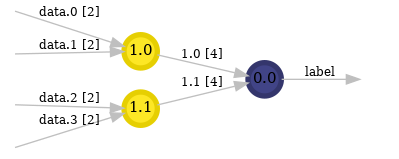

In [45]:
DEVICE = 'cuda'
BOND_DIM = 10
DTYPE = torch.float
N_LABELS = 3

model = TTNModel(features, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE)
model.draw()

In [46]:
INIT_EPOCHS = 3

model.initialize(True, train_dl, loss, INIT_EPOCHS)

ttn supervised init:   0%|          | 0/1 [00:01<?, ?it/s, doing epoch 3/3]


In [47]:
#print(check_correct_init(model))
summary(model, input_size=(BATCH_SIZE, features, 2), dtypes=[DTYPE], device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [128, 3]                  80
Total params: 80
Trainable params: 80
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [21]:
LR = 0.02
EPOCHS = 80
LAMBDA = 0.1
SCHEDULER_STEPS = 4


model.train()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
scheduler = schedulers[0]

In [22]:

tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS, desc='epochs', position=0):
    loss_history = train_one_epoch(model, DEVICE, train_dl, lambda *x: loss(*x, l=LAMBDA), optimizer)
    tot_loss_history += loss_history
    if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
        scheduler.step()

    
loss_history = np.array(tot_loss_history)

epochs: 100%|██████████| 80/80 [00:59<00:00,  1.34it/s]


In [23]:
accuracy(model, DEVICE, train_dl, test_dl, DTYPE)

train: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


(0.95, 0.9666666666666667)

In [24]:
torch.save(model.state_dict, f'models/trainedmodel_{DATASET}_bond{BOND_DIM}_type{str(DTYPE).split(".")[1]}_{now.strftime("%Y%m%d-%H%M%S")}.dict')
np.save(f'models/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.npy', loss_history)

### Plots

3.4249245895053853


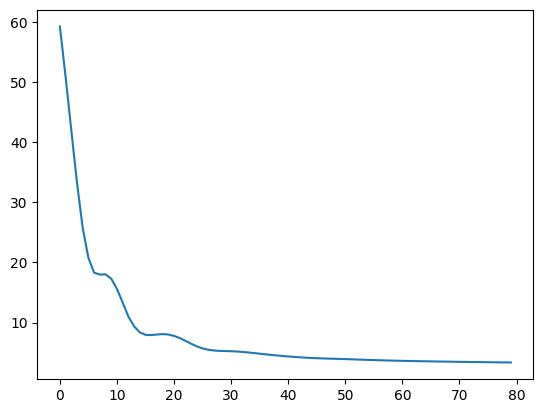

In [24]:
plt.plot(range(len(loss_history)), loss_history)
#plt.ylim(0, 2)
print(np.mean(loss_history[-10:]))

/tmp/ipykernel_284897/3371480203.py:3: RuntimeWarning: Mean of empty slice.
  ax.plot([loss_history[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else -1)].mean() for i in range(EPOCHS)])
/home/ubuntu/data/ttn4hep/.ttn_venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


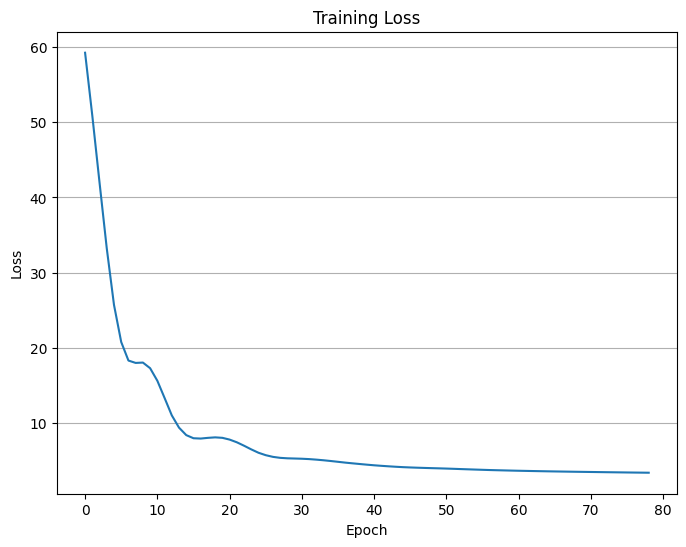

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot([loss_history[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else -1)].mean() for i in range(EPOCHS)])
#ax.set_ylim(0, 0.3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.grid(axis='y')

fig.savefig(f'models/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.png')

In [26]:
def get_predictions(model, device, dl, dtype=torch.complex128, disable_pbar=False):

    model.eval()
    model.to(device)
    predictions = []
    with torch.no_grad():
        for data in tqdm(dl, total=len(dl), position=0, desc='test', disable=disable_pbar):
            images, labels = data
            images, labels = images.to(device, dtype=dtype).squeeze(), labels.to(device)
            outputs = model(images)
            probs = torch.real(torch.pow(outputs, 2))
            #probs = probs / torch.sum(probs)
            predictions.append(probs.squeeze().detach().cpu())

    return torch.concat(predictions, dim=0)


def get_output(model, device, dl, dtype=torch.complex128, disable_pbar=False):

    model.eval()
    model.to(device)
    outputs = []
    with torch.no_grad():
        for data in tqdm(dl, total=len(dl), position=0, desc='test', disable=disable_pbar):
            images, labels = data
            images, labels = images.to(device, dtype=dtype).squeeze(), labels.to(device)
            outputs.append(model(images).squeeze().detach().cpu())

    return torch.concat(outputs, dim=0)

test: 100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


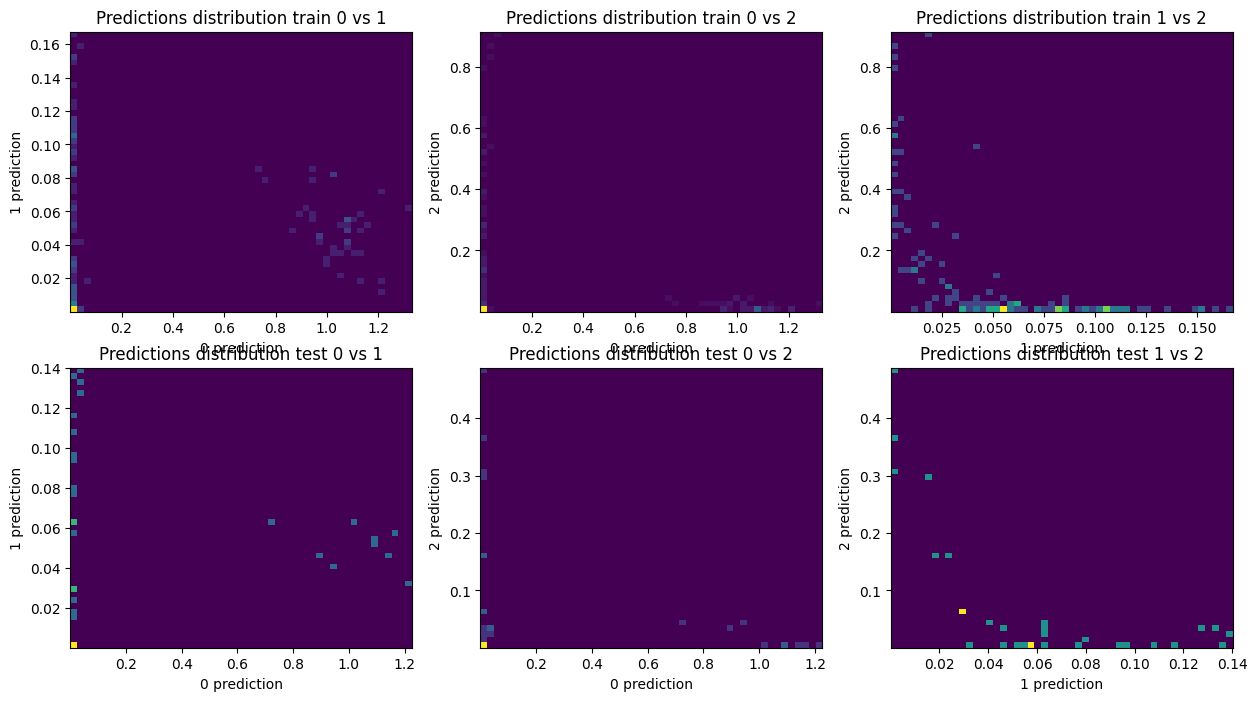

In [27]:
import sys
sys.path.insert(0, '../')
from images.plot_utils import plot_predictions

train_pred = get_predictions(model, DEVICE, train_dl, DTYPE)
test_pred = get_predictions(model, DEVICE, test_dl, DTYPE)

fig, axa = plot_predictions(train_pred, test_pred, N_LABELS)

fig.savefig(f'models/predictions_dist_{now.strftime("%Y%m%d-%H%M%S")}.png')

In [30]:
# save model output
train_out = get_output(model, DEVICE, train_dl, DTYPE)
test_out = get_output(model, DEVICE, test_dl, DTYPE)
np.save(f'models/train_out_{now.strftime("%Y%m%d-%H%M%S")}.npy', train_out)
np.save(f'models/test_out_{now.strftime("%Y%m%d-%H%M%S")}.npy', test_out)

test:   0%|          | 0/79 [00:00<?, ?it/s]

test: 100%|██████████| 8/8 [00:00<00:00, 647.31it/s]


In [31]:
#save model weights
np.savez(f'models/weights_{now.strftime("%Y%m%d-%H%M%S")}.npz', **{key.name : value.cpu().detach() for key, value in model._TTN__tensor_map.items()})

## Get weights distribution

In [43]:
def get_weights_population(n, dataloader, disable_pbar=False, **kws):
    weights_ls = []
    DEVICE = 'cuda'
    BATCH_SIZE = 64
    DTYPE = torch.double
    INIT_EPOCHS = 4
    LR = 0.05
    EPOCHS = 80
    SCHEDULER_STEPS = 4
    train_dl, test_dl, features = dataloader(batch_size=BATCH_SIZE, **kws)

    N_LABELS = next(iter(train_dl))[1].shape[1]
    
    pbar = tqdm(total=n*EPOCHS*len(train_dl), position=0, desc='weights population', leave=True, disable=disable_pbar)
    for _ in range(n):        
        model = TTNModel(features, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE)
        model.initialize(True, train_dl, loss, INIT_EPOCHS, disable_pbar=True)
        model.train()
        model.to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
        schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
        scheduler = schedulers[0]
        tot_loss_history = []
        for epoch in range(EPOCHS):
            loss_history = train_one_epoch(model, DEVICE, train_dl, loss, optimizer, pbar=pbar, disable_pbar=disable_pbar)
            tot_loss_history += loss_history
            if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
                scheduler.step()

        loss_history = np.array(tot_loss_history)
        print('Accuracy on train and test set:', accuracy(model, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True))

        weights = [tensor.detach().cpu().flatten() for tensor in model.tensors]
        weights_ls.append(torch.concat(weights, dim=0))
        train_dl, test_dl, h = dataloader(batch_size=BATCH_SIZE, **kws)
    return torch.stack(weights_ls)

In [44]:
BOND_DIM = 4
weights = get_weights_population(2, get_iris_data_loaders, sel_labels=['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'])

weights population:  50%|█████     | 160/320 [00:34<00:32,  4.88it/s, current loss=0.877, batches -10-0 loss=0, epoch mean loss=1.19]

Accuracy on train and test set: (0.975, 0.9)


weights population: 100%|██████████| 320/320 [01:10<00:00,  4.54it/s, current loss=1.37, batches -10-0 loss=0, epoch mean loss=1.19] 

Accuracy on train and test set: (0.975, 0.9333333333333333)


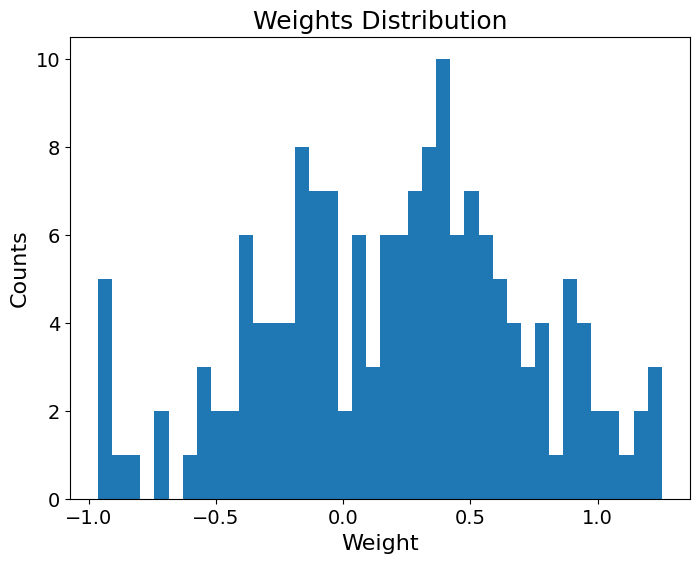

In [46]:
weights_plt = weights.flatten().numpy()
np.save(f'models/weights_{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.npy', weights.numpy())
FS = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(weights_plt, bins=40)
ax.set_xlabel('Weight', fontsize=FS)
ax.set_ylabel('Counts', fontsize=FS)
ax.set_title('Weights Distribution', fontsize=FS+2)
ax.tick_params(axis='both', which='major', labelsize=FS-2)
#ax.set_yticklabels(ax.get_yticks(), fontsize=FS-2)

fig.savefig(f'models/weight_distribution_{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.svg')

In [47]:
print('min', np.abs(weights.numpy()).min(), 'max', np.abs(weights.numpy()).max(), sep='\n')

min
0.0005776366110182861
max
1.2521913524434551


# Quantized model

In [1]:
from qtorch import FixedPoint, FloatingPoint
from qtorch.quant import Quantizer, fixed_point_quantize
from qtorch.optim import OptimLP

wl = 16
fl = 14

forward_num = FixedPoint(wl=wl, fl=fl)
backward_num = FixedPoint(wl=wl, fl=fl)

# Create a quantizer
Q = Quantizer(forward_number=forward_num, backward_number=backward_num,
              forward_rounding="nearest", backward_rounding="stochastic")

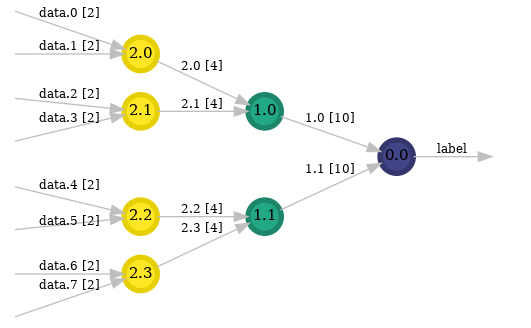

In [119]:
DEVICE = 'cuda'
BOND_DIM = 10
DTYPE = torch.float        # we use float for the quantization, as qtorch does not support double
N_LABELS = 1

qmodel = TTNModel(features, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE, quantizer=Q)
qmodel.draw()

In [120]:
INIT_EPOCHS = 3

qmodel.initialize(True, train_dl, loss, INIT_EPOCHS)
summary(qmodel, input_size=(BATCH_SIZE, features, 2), dtypes=[DTYPE], device=DEVICE)

ttn supervised init:   0%|          | 0/79 [00:03<?, ?it/s, doing epoch 3/3]


Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [128, 1]                  484
├─Quantizer: 1-1                         [2, 2, 4]                 --
├─Quantizer: 1-2                         [128, 2]                  --
├─Quantizer: 1-3                         [128, 8]                  --
├─Quantizer: 1-4                         [128, 2]                  --
├─Quantizer: 1-5                         [128, 1, 4]               --
├─Quantizer: 1-6                         [2, 2, 4]                 --
├─Quantizer: 1-7                         [128, 2]                  --
├─Quantizer: 1-8                         [128, 8]                  --
├─Quantizer: 1-9                         [128, 2]                  --
├─Quantizer: 1-10                        [128, 1, 4]               --
├─Quantizer: 1-11                        [2, 2, 4]                 --
├─Quantizer: 1-12                        [128, 2]                  --
├─Quantizer: 1

In [121]:
LR = 0.02
EPOCHS = 80
LAMBDA = 0.1
SCHEDULER_STEPS = 4


qmodel.train()
qmodel.to(DEVICE)
optimizer = torch.optim.Adam(qmodel.parameters(), lr=LR, weight_decay=1e-4)
# define custom quantization functions for different numbers
weight_quant = lambda x : fixed_point_quantize(x, 16, 14, rounding="nearest")
# turn your optimizer into a low precision optimizer
optimizer = OptimLP(optimizer,
                    weight_quant=weight_quant)
schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
scheduler = schedulers[0]

In [122]:

tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS, desc='epochs', position=0):
    loss_history = train_one_epoch(qmodel, DEVICE, train_dl, lambda *x: loss(*x, l=LAMBDA), optimizer)
    tot_loss_history += loss_history
    if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
        scheduler.step()

    
loss_history = np.array(tot_loss_history)

epochs:   0%|          | 0/80 [00:00<?, ?it/s]

epochs: 100%|██████████| 80/80 [02:21<00:00,  1.77s/it]


In [123]:
accuracy(qmodel, DEVICE, train_dl, test_dl, DTYPE)

train:   0%|          | 0/79 [00:00<?, ?it/s]

train: 100%|██████████| 79/79 [00:00<00:00, 93.98it/s] 


(0.7504, 0.762)

In [23]:
torch.load('data/grid_search/model_8_4_16_False_torch.float64.pth')['_TTN__tensors.0']

tensor([[[-3.7677e-04],
         [-1.5435e-02],
         [-1.8145e-04],
         [-6.1096e-04]],

        [[-7.9009e-04],
         [ 1.0263e+00],
         [ 5.1388e-05],
         [ 1.5473e-04]],

        [[ 7.0854e-04],
         [-3.7704e-03],
         [-9.0056e-05],
         [-2.6149e-04]],

        [[ 1.3896e-06],
         [ 3.0381e-06],
         [-4.7425e-08],
         [ 3.6490e-08]]], device='cuda:0', dtype=torch.float64)